In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import scipy.signal as signal
from scipy.signal import get_window
from scipy.fft import fft
from scipy.signal import hilbert

from enfify.synthetic_signals import generate_s_tone, generate_random_number
from enfify.enf_estimation import hilbert_instantaneous_freq, phase_estimation_DFT0
#from enfify.enf_enhancement import VMD
from enfify.synthetic_signals import func_ENF_synthesis_corrupted_harmonic
from enfify.preprocessing import bandpass_filter

In [12]:
def scipy_IF_estimation(sig, fs):

    nperseg = 80
    freqs,times,stft = signal.stft(sig, fs=fs, nperseg=nperseg) # Apply STFT
    peak_freqs = [freqs[idx] for t in range(len(times)) if (idx := np.argmax(stft[:,t]))] # Extract peak for each point in time

    return peak_freqs

def freq_err(freq, estimate_freq):
    return np.abs(estimate_freq-freq)

def segmented_freq_estimation_DFT0(s_in, f_s, num_cycles, N_DFT, step_size):
    #step_size = int(f_s // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq,_ = phase_estimation_DFT0(segments[i], f_s, N_DFT)
        freqs.append(freq)

    freqs = np.array(freqs)
    
    return freqs

def segmented_freq_estimation_DFT1(s_in, f_s, num_cycles, N_DFT, step_size):

    #step_size = f_s  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq = freq_estimation_DFT1(segments[i], f_s, N_DFT)
        freqs.append(freq)

    freqs = np.array(freqs)
    
    return freqs

def segmented_freq_estimation_hilbert(s_in, f_s, num_cycles, step_size):
    #step_size = f_s  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq = hilbert_instantaneous_freq(segments[i],f_s)
        freq = np.mean(freq)
        freqs.append(freq)

    freqs = np.array(freqs)
    
    return freqs
    
def segmented_scipy_freq_estimation(s_in, f_s, num_cycles, step_size):
    #step_size = int(f_s // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq = scipy_IF_estimation(segments[i],f_s)
        freq = np.mean(freq)
        freqs.append(freq)
    
    freqs = np.array(freqs)
    
    return freqs

def freq_estimation_DFT1(s_tone, Fs, N_DFT):

    ###......Estimate the frequency......###
    window_type = 'hann'
    M = len(s_tone)
    s_tone_unmodified = s_tone
    # Get the window type
    window = get_window(window_type, M-1)
    
    # Calculate the approx. first derivative of single tone
    s_tone_diff = Fs * np.diff(s_tone)
    s_tone = s_tone[1:]

    # Windowing
    s_tone_windowed = s_tone * window
    s_tone_diff_windowed = s_tone_diff * window

    # Zero-Padding of the signal
    s_tone_padded = np.pad(s_tone_windowed, (0, N_DFT - M), 'constant')
    s_tone_padded_diff = np.pad(s_tone_diff_windowed, (0, N_DFT - M), 'constant')

    # Calculate the DFT
    X = fft(s_tone_windowed,n=N_DFT)
    X_diff = fft(s_tone_diff_windowed,n=N_DFT)

    # Compute the amplitude spectrum and max. amplitude
    abs_X = np.abs(X)
    k_max = np.argmax(abs_X)
    abs_X_diff = np.abs(X_diff)

    # Estimated frequency of the single tone
    F_kmax = (np.pi * k_max) / (N_DFT * np.sin(np.pi * k_max/ N_DFT))
    f0_estimated = (F_kmax * abs_X_diff[k_max]) / (2 * np.pi * abs_X[k_max])

    return f0_estimated



import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import IPython.display as ipd
from numba import jit
import libfmp.b

%matplotlib inline

@jit(nopython=True)
def principal_argument(v):
    """Principal argument function

    Args:
        v (float or np.ndarray): Value (or vector of values)

    Returns:
        w (float or np.ndarray): Principle value of v
    """
    w = np.mod(v + 0.5, 1) - 0.5
    return w

@jit(nopython=True)
def compute_if(X, Fs, N, H):
    """Instantenous frequency (IF) estamation

    | Notebook: C8/C8S2_InstantFreqEstimation.ipynb, see also
    | Notebook: C6/C6S1_NoveltyPhase.ipynb

    Args:
        X (np.ndarray): STFT
        Fs (scalar): Sampling rate
        N (int): Window size in samples
        H (int): Hop size in samples

    Returns:
        F_coef_IF (np.ndarray): Matrix of IF values
    """
    phi_1 = np.angle(X[:, 0:-1]) / (2 * np.pi)
    phi_2 = np.angle(X[:, 1:]) / (2 * np.pi)

    K = X.shape[0]
    index_k = np.arange(0, K).reshape(-1, 1)
    # Bin offset (FMP, Eq. (8.45))
    kappa = (N / H) * principal_argument(phi_2 - phi_1 - index_k * H / N)
    # Instantaneous frequencies (FMP, Eq. (8.44))
    F_coef_IF = (index_k + kappa) * Fs / N

    # Extend F_coef_IF by copying first column to match dimensions of X
    F_coef_IF = np.hstack((np.copy(F_coef_IF[:, 0]).reshape(-1, 1), F_coef_IF))

    return F_coef_IF


def plot_IF(F_coef_X, F_coef_IF, ylim, Fs, H, N, figsize=(10,3)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,3,1)
    libfmp.b.plot_matrix(F_coef_X, Fs=Fs/H, Fs_F=N/Fs, cmap='PuOr', clim=ylim, ax=[ax],
            title=r'$F_\mathrm{coef}$')
    plt.ylim(ylim)
    ax = plt.subplot(1,3,2)
    libfmp.b.plot_matrix(F_coef_IF, Fs=Fs/H, Fs_F=N/Fs, cmap='PuOr', clim=ylim, ax=[ax],
            title=r'$F_\mathrm{coef}^\mathrm{IF}$')
    plt.ylim(ylim)
    ax = plt.subplot(1,3,3)
    libfmp.b.plot_matrix(F_coef_IF-F_coef_X, Fs=Fs/H, Fs_F=N/Fs, cmap='seismic', ax=[ax],
            title=r'$F_\mathrm{coef}^\mathrm{IF}-F_\mathrm{coef}$')
    plt.ylim(ylim)
    plt.tight_layout()

def compute_mean_frequency_over_time(X, F_coef_IF):
    """Compute the mean (weighted mean) frequency over time.
    
    Args:
        X (np.ndarray): STFT matrix (complex-valued).
        F_coef_IF (np.ndarray): Instantaneous frequency matrix.
        
    Returns:
        mean_freq (np.ndarray): 1D array of mean frequencies over time.
    """
    # Magnitude of STFT values (|X|)
    magnitude = np.abs(X)

    # Weighted mean of instantaneous frequencies for each time frame
    weighted_sum = np.sum(F_coef_IF * magnitude, axis=0)
    magnitude_sum = np.sum(magnitude, axis=0)

    # Avoid division by zero
    magnitude_sum[magnitude_sum == 0] = 1e-10  # Small epsilon value

    mean_freq = weighted_sum / magnitude_sum

    return mean_freq

def compute_max_energy_frequency_over_time(X, F_coef_IF):
    """Compute the dominant frequency over time based on max energy.
    
    Args:
        X (np.ndarray): STFT matrix (complex-valued).
        F_coef_IF (np.ndarray): Instantaneous frequency matrix.
        
    Returns:
        max_energy_freq (np.ndarray): 1D array of dominant frequencies over time.
    """
    # Magnitude of STFT values (|X|)
    magnitude = np.abs(X)

    # Find the index of the frequency bin with maximum magnitude in each time frame
    max_energy_indices = np.argmax(magnitude, axis=0)

    # Use these indices to extract the corresponding instantaneous frequencies
    max_energy_freq = F_coef_IF[max_energy_indices, np.arange(F_coef_IF.shape[1])]

    return max_energy_freq


In [167]:
# Hilbert instantaneous phase estimation
def hilbert_instantaneous_phase(signal):
    analytic_sig = hilbert(signal)
    inst_phase  = np.unwrap(np.angle(analytic_sig))
    return inst_phase

def segmented_phase_estimation_hilbert(s_in, f_s, num_cycles, nominal_enf):

    step_size = int(f_s // nominal_enf)
    print(step_size)

    num_blocks = len(s_in) // step_size - (num_cycles - 1)
    print(num_blocks)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]
    print(len(segments))

    phases = []
    for i in range(len(segments)):
        phase = hilbert_instantaneous_phase(segments[i])
        phase = np.mean(phase)
        phases.append(phase)
    
    phases = np.unwrap(phases)
    phases = np.array(phases)

    return phases


In [ ]:
# Create synthetic ENF Signal and noised ENF Signal
pole = 0.99
GT_freq  = 50
mean_value = 50
std_deviation = 0.04
fs = 1000
phi0 = np.pi/4
period_len = int(fs/GT_freq)
n_freq = 50*period_len

### Create ENF Signal
wgn = np.random.normal(0, 1, n_freq)
f_n = np.ones(n_freq) * GT_freq

for n in range(1, n_freq):
    f_n[n] = pole * f_n[n-1] + wgn[n]

f_n = f_n * std_deviation / np.std(f_n)
f_n = f_n + mean_value


period_len = 10 * 60
n = np.arange(int(period_len * fs)) 
enf_sig = np.array([])
current_phase = phi0

# Generate the ENF signal
for f in f_n:
    sig = np.cos((2 * np.pi * f * n[:int(fs)]) / fs + current_phase)
    current_phase += 2 * np.pi * f * len(n[:int(fs)]) / fs
    enf_sig = np.concatenate((enf_sig, sig))

plt.figure(figsize=(10,2))
plt.plot(enf_sig)
plt.show()

### Create noise 
n, s_n = generate_s_tone(fs, GT_freq, phi0, len(n))
s_watts = s_n** 2

# Adding noise using target SNR
# Set a target SNR
target_snr_db = -20

# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(s_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)

# Calculate noise and convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)

# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(s_watts))

# Noise up the original signal
s_n_noised = enf_sig + noise_volts

plt.figure(figsize=(10,2))
plt.plot(s_n_noised)
plt.show()

num_cycles = 10


In [3]:
FUNDAMENTAL_ENF = 50  # ENF freq
HARMONIC_INDEX = np.array([1, 2, 3, 4, 5, 6])
CORRUPTED_INDEX = np.array([2, 5, 6])
DURATION = 60  # in seconds
FS = 1000  # sampling freq
NUMBER = 1000  # Number of signals

sig, enf_freqs, sig_harmonics = func_ENF_synthesis_corrupted_harmonic(FUNDAMENTAL_ENF, HARMONIC_INDEX, CORRUPTED_INDEX, DURATION, FS, True)

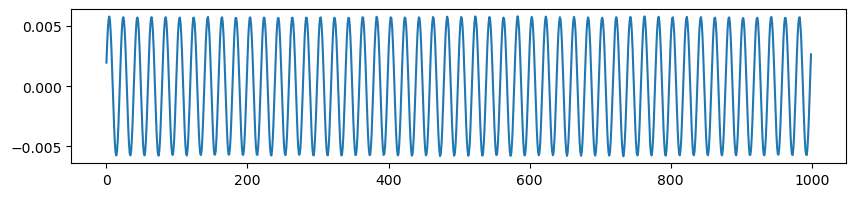

[49.99981223 49.99970057 49.99958001 ... 50.07148387 50.07119333
 50.07132913]


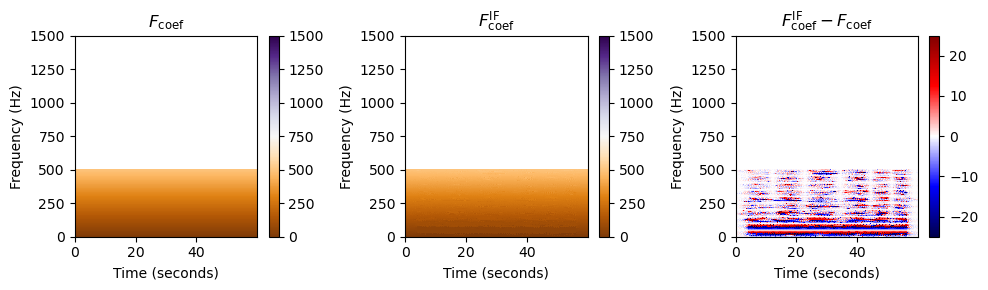

In [13]:
plt.figure(figsize=(10,2))
plt.plot(sig_harmonics[0][55_000:56_000])
plt.show()

#for i in range(len(enf_freqs[0])):
    #print(enf_freqs[0][i])

print(enf_freqs[0])

N = 8001
H = 20
X = librosa.stft(sig_harmonics[0], n_fft=N, hop_length=H, win_length=N, window='hamming')
Y = np.log(1+ 10*np.abs(X))
K = X.shape[0]
L = X.shape[1]
ylim = [0,1500]

F_coef_IF = compute_if(X, FS, N, H)
F_coef = np.arange(K) * FS / N
F_coef_X = np.ones((K,L)) * F_coef.reshape(-1,1)
plot_IF(F_coef_X, F_coef_IF, ylim, FS, H, N) 


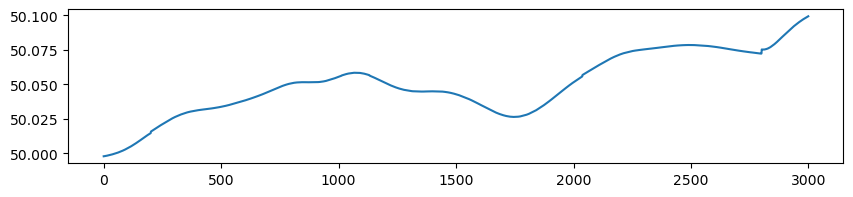

In [25]:
N = 8001
H = 20
X = librosa.stft(sig_harmonics[0], n_fft=N, hop_length=H, win_length=N, window='hamming')
Y = np.log(1+ 10*np.abs(X))
K = X.shape[0]
L = X.shape[1]
ylim = [0,1500]

F_coef_IF = compute_if(X, FS, N, H)
max_energy_freq = compute_max_energy_frequency_over_time(X, F_coef_IF)

len(max_energy_freq)
plt.figure(figsize=(10,2))
plt.plot(max_energy_freq)
plt.show()

In [26]:
# Synthetic ENF Signal
N_DFT = 20_000
fs = 1000
nominal_enf = 50
step_size = int(fs // nominal_enf)
num_cycles = 400
enf_sig = sig_harmonics[0]
f_n = enf_freqs[0]

# DFT0
DFT0_freqs = segmented_freq_estimation_DFT0(enf_sig, fs, num_cycles, N_DFT, step_size)

sig_len = int(len(enf_sig)/len(DFT0_freqs))
DFT0_freqs_new = np.ones(len(enf_sig))

for l in range(len(DFT0_freqs)):
    DFT0_freqs_new[l*sig_len:(2*sig_len + 2*l*sig_len)] = DFT0_freqs[l]

freq_error_DFT0 = []
for i in range(len(DFT0_freqs_new)):
    freq_error_DFT0.append(freq_err(f_n[i], DFT0_freqs_new[i]))

print(f'Mean error DFT0: {np.mean(freq_error_DFT0)}')


# DFT1
DFT1_freqs = segmented_freq_estimation_DFT1(enf_sig, fs, num_cycles, N_DFT, step_size)

sig_len = int(len(enf_sig)/len(DFT1_freqs))
DFT1_freqs_new = np.ones(len(enf_sig))

for l in range(len(DFT1_freqs)):
    DFT1_freqs_new[l*sig_len:(2*sig_len + 2*l*sig_len)] = DFT1_freqs[l]

freq_error_DFT1 = []
for i in range(len(DFT1_freqs_new)):
    freq_error_DFT1.append(freq_err(f_n[i], DFT1_freqs_new[i]))

print(f'Mean error DFT1: {np.mean(freq_error_DFT1)}')


# Hilbert Segments
Hilbert_freqs = segmented_freq_estimation_hilbert(enf_sig, fs, num_cycles, step_size)
new_freqs_hilbert = np.ones(len(enf_sig))

for l in range(len(Hilbert_freqs)):
    new_freqs_hilbert[l*sig_len:(2*sig_len + 2*l*sig_len)] = Hilbert_freqs[l]

freq_error_hilbert = []
for i in range(len(new_freqs_hilbert)):
    freq_error_hilbert.append(freq_err(f_n[i],new_freqs_hilbert[i]))

print(f'Mean error Hilbert Segments: {np.mean(freq_error_hilbert)}')


# Hilbert
Hilbert_freqs = hilbert_instantaneous_freq(enf_sig, fs)

freq_error = []
for i in range(len(enf_sig)):
    freq_error.append(freq_err(f_n[i],Hilbert_freqs[i]))

print(f'Mean error Hilbert: {np.mean(freq_error)}')


# Scipy
scipy_freqs = segmented_scipy_freq_estimation(enf_sig, fs, num_cycles, step_size)
new_freqs_scipy = np.ones(len(enf_sig))

for l in range(len(scipy_freqs)):
    new_freqs_scipy[l*sig_len:(2*sig_len + 2*l*sig_len)] = scipy_freqs[l]

freq_error_scipy = []
for i in range(len(new_freqs_hilbert)):
    freq_error_scipy.append(freq_err(f_n[i], new_freqs_scipy[i]))

print(f'Mean error Scipy: {np.mean(freq_error_scipy)}')


# STFT Maximum value
N = 8001
H = 20
X = librosa.stft(sig_harmonics[0], n_fft=N, hop_length=H, win_length=N, window='hamming')
Y = np.log(1+ 10*np.abs(X))
K = X.shape[0]
L = X.shape[1]
ylim = [0,1500]

F_coef_IF = compute_if(X, FS, N, H)
max_energy_freq = compute_max_energy_frequency_over_time(X, F_coef_IF)

sig_len = int(len(enf_sig)/len(max_energy_freq))
max_energy_freq_new = np.ones(len(enf_sig))

for l in range(len(max_energy_freq)):
    max_energy_freq_new[l*sig_len:(2*sig_len + 2*l*sig_len)] = max_energy_freq[l]

freq_error_STFT = []
for i in range(len(max_energy_freq_new)):
    freq_error_STFT.append(freq_err(f_n[i], max_energy_freq_new[i]))

print(f'Mean error STFT: {np.mean(freq_error_STFT)}')

Mean error DFT0: 0.015868517715080126
Mean error DFT1: 0.00613449530762101
Mean error Hilbert Segments: 0.05496365572854642
Mean error Hilbert: 0.5389439101721764
Mean error Scipy: 6.998324429789861
Mean error STFT: 0.004116200958655775


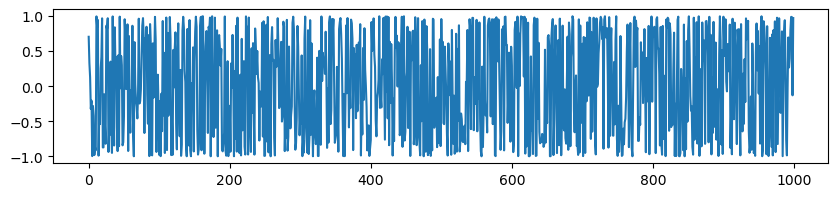

Mean error DFT0: 181.67243
Mean error DFT1: 181.63132785202993
Mean error Hilbert Segments: 127.88062585442889
Mean error Hilbert: 211.08077245936997


In [48]:
# Generate random signal
n_samples = 1000
fs = 1000
phi0 = np.pi/4
random_signal = []
random_freqs = []
n = np.arange(n_samples)

for i in range(n_samples):
    random_freq = generate_random_number(20, 80, 2)
    random_freqs.append(random_freq)
    random_signal.append(np.cos((2 * np.pi * random_freq * n[i])/fs + phi0))

#plt.figure(figsize=(10,2))
#plt.plot(random_signal)
#plt.show()

# Random Signal
N_DFT = 20_000
nominal_enf = 50
step_size = int(fs // nominal_enf)
num_cycles = 10

# DFT0
DFT0_freqs = segmented_freq_estimation_DFT0(random_signal, fs, num_cycles, N_DFT, step_size)

sig_len = int(len(random_signal)/len(DFT0_freqs))
DFT0_freqs_new = np.ones(len(random_freqs))

for l in range(len(DFT0_freqs)):
    DFT0_freqs_new[l*sig_len:(2*sig_len + 2*l*sig_len)] = DFT0_freqs[l]

freq_error_DFT0 = []
for i in range(len(DFT0_freqs_new)):
    freq_error_DFT0.append(freq_err(random_freqs[i], DFT0_freqs_new[i]))

print(f'Mean error DFT0: {np.mean(freq_error_DFT0)}')


# DFT1
DFT1_freqs = segmented_freq_estimation_DFT1(random_signal, fs, num_cycles, N_DFT, step_size)

sig_len = int(len(random_signal)/len(DFT1_freqs))
DFT1_freqs_new = np.ones(len(random_freqs))

for l in range(len(DFT1_freqs)):
    DFT1_freqs_new[l*sig_len:(2*sig_len + 2*l*sig_len)] = DFT1_freqs[l]

freq_error_DFT1 = []
for i in range(len(DFT1_freqs_new)):
    freq_error_DFT1.append(freq_err(random_freqs[i], DFT1_freqs_new[i]))

print(f'Mean error DFT1: {np.mean(freq_error_DFT1)}')


# Hilbert Segments
Hilbert_freqs = segmented_freq_estimation_hilbert(random_signal, fs, num_cycles, step_size)
new_freqs_hilbert = np.ones(len(random_freqs))

for l in range(len(Hilbert_freqs)):
    new_freqs_hilbert[l*sig_len:(2*sig_len + 2*l*sig_len)] = Hilbert_freqs[l]

freq_error_hilbert = []
for i in range(len(new_freqs_hilbert)):
    freq_error_hilbert.append(freq_err(random_freqs[i], new_freqs_hilbert[i]))

print(f'Mean error Hilbert Segments: {np.mean(freq_error_hilbert)}')

# Hilbert
Hilbert_freqs = hilbert_instantaneous_freq(random_signal, fs)

freq_error = []
for i in range(len(random_freqs)):
    freq_error.append(freq_err(random_freqs[i], Hilbert_freqs[i]))

print(f'Mean error Hilbert: {np.mean(freq_error)}')


In [16]:
alpha = 5000 # moderate bandwidth constraint
tau = 0 
n_mode = 2
DC = 0  # no DC part imposed  
tol = 1e-7
u_clean, u_hat_clean, omega_clean = VMD(s_n_noised[:1000], alpha, tau, n_mode, DC, tol)

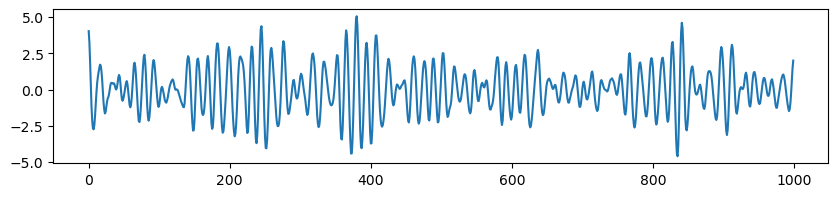

Mean error Hilbert Segments: 17.13779050313186


In [17]:
plt.figure(figsize=(10,2))
plt.plot(u_clean[0])
plt.show()

Hilbert_freqs = segmented_freq_estimation_hilbert(u_clean[0], fs, num_cycles, step_size)
new_freqs_hilbert = np.ones(len(u_clean[0]))

for l in range(len(Hilbert_freqs)):
    new_freqs_hilbert[l*sig_len:(2*sig_len + 2*l*sig_len)] = Hilbert_freqs[l]

freq_error_hilbert = []
for i in range(len(new_freqs_hilbert)):
    freq_error_hilbert.append(freq_err(f_n[:1000][i],new_freqs_hilbert[i]))

print(f'Mean error Hilbert Segments: {np.mean(freq_error_hilbert)}')